In [10]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.integrate as integrate
from scipy.optimize import fsolve

In [11]:
data=np.random.rand(100,10)
U, S, Vt = np.linalg.svd(data, full_matrices=0)
diag_s=np.diag(S)
svd= U @ diag_s @ Vt

'''
Unitary matrix that when multiplied does not change the original data 
I= U @ U.T
I2=Vt @ Vt.T
print(data @ I2)
print(I @ data)
'''


'\nUnitary matrix that when multiplied does not change the original data \nI= U @ U.T\nI2=Vt @ Vt.T\nprint(data @ I2)\nprint(I @ data)\n'

<h2><bold>Investigating geometry of recursive dyatic sum<bold> </h2>
<p>We define the dyatic sum of an SVD as the sum of rank one matrices.
So the dyatic sum of a svd matrix is the sum of the rth singular value multiplied by the outer product of the column vector U and column vector of V transpose.
We then investigate the geometry of a recursive dyatic sum, particulary the geometry of frobenius norm. 
Eventually the frobenius norm tend to move to zero for each depth value the matrix is decomposed, giving us a 'life signal' representing less and lesser important matrix.

We could eventually investigate the potential for recostructing the original matrix, to maybe find a speedier calculation method for matrix recompositon if we ever need one
</p>

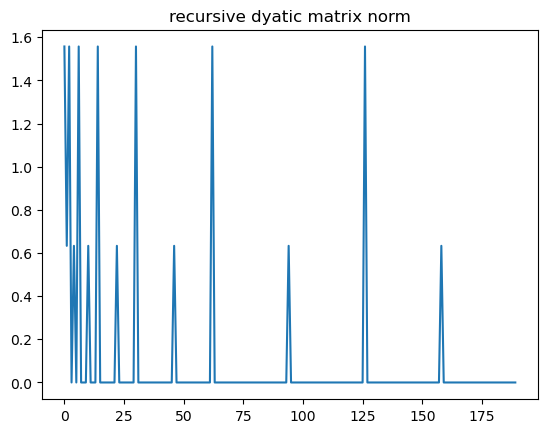

In [12]:

class node:
    def __init__(self,data,level,f_norm):
        self.data=data
        self.level=level
        self.f_norm=f_norm
    def __str__(self):
        return str(self.level)
class pila:
    def __init__(self):
        self.stack=[]
    def push(self,data,level,fnorm):
        g=node(data,level, fnorm)
        self.stack.append(g)
        self.stack=sorted(self.stack, key = lambda x: x.level)
    def __str__(self):
        return '\n'.join( [str(elem) for elem in self.stack])
    def __getitem__(self,index):
        return self.stack[index]
            

global P
P=pila()

def rec_dyatic_sum(U,S,Vt,M=0):
    global P

    for x in range(0,len(S)):
        d_sum= S[x] * np.outer(U[:,x], Vt[:,x])
        somma_frobenius=0
        for i in range(len(d_sum)):
            for k in range(len(d_sum[0])):
                somma_frobenius+=abs(d_sum[i,k])**2
        norma_frobenius=np.sqrt(somma_frobenius)
       
        Ud, Sd, Vd = np.linalg.svd(d_sum, full_matrices=1)
        
        P.push(d_sum,M,norma_frobenius )

        if M <= 5:     
            k=rec_dyatic_sum(Ud, Sd, Vd, M+1)
        else:
            return
        
    return 
    

data=np.random.rand(2,10)
U, S, Vt = np.linalg.svd(data, full_matrices=0)
diag_s=np.diag(S)

matrix=np.array(rec_dyatic_sum(U,S,Vt))

P_norm=[]
for x in range(len(P.stack)):
    P_norm.append(P[x].f_norm)
plt.title('recursive dyatic matrix norm')
plt.plot(np.arange(len(P_norm)),P_norm)

<h2>Snapshot method for efficient svd computation </h2>
<p>We know computing the dot product of X and X Transpose to be computationally challenging. Snapshot method leverage a much simpler calculation, the dot product of X transpose X resulting in a mxm matrix.
We then extract the singular value and build S, and V (the eigenvectors of Xt*X).
Then we could just apply the inverse formula U=data @ V @ the inverse of sigma to compute U

</p>

In [13]:
#defining snapshot method for efficient svd computation

def snapshot_svd(data):
    XtX=data.T @ data

    eg_value, eg_vectors=np.linalg.eigh(XtX)
    sg_value=np.sqrt(eg_value)

    S=np.diag(np.sort(sg_value)[::-1])
    V= eg_vectors
    U= data @ V @ np.linalg.inv(S)
    return U, S, V.T

def calculate_operation(data, other):
    operations=((2*data.shape[1])-1)*data.shape[0]*other.shape[1]
    return operations

data=np.random.randn(120,4)
U, S, Vt=snapshot_svd(data)
print('X*X.T operations:',calculate_operation(data, data.T), ' X.T*X operations', calculate_operation(data.T, data))


X*X.T operations: 100800  X.T*X operations 3824


In [14]:

SQ_matrix=np.random.randn(100,100)
RT_matrix=np.random.rand(100,5)

magnitude=0.5

noise_sq=np.random.randn(SQ_matrix.shape[0], SQ_matrix.shape[1])
noised_data_sq=SQ_matrix+ (magnitude*noise_sq)

noised_rt=np.random.rand(RT_matrix.shape[0], RT_matrix.shape[1])
noised_data_rt=RT_matrix + (magnitude * noised_rt)

#closed form for an M nxn matrix with noise known
closed_form_SQ=(4/np.sqrt(3)) * np.sqrt(SQ_matrix.shape[0]) * magnitude

#closed form for a M nxm rectangular matrix where n>>m , we replace the 4/sqrt(3) value in the sqrt hard limit formula with a function lambda


B=RT_matrix.shape[1]/RT_matrix.shape[0]
#formula is: LambdaFunction(B)*sqrt(n)*magnitude where B=m/n and LambdaFunction=sqrt: (2(B+1) + (8B/ (B+1+ sqrt(B**2+13B+1)))) 
l_function=np.sqrt((2*(B+1) + (8*B / (B+1+ np.sqrt(B**2 + 14*B +1)))))
closed_form_RT= l_function *  np.sqrt(RT_matrix.shape[0]) * magnitude
 
print('Optimal hard threeshold for square matrix singular values: ', np.round(closed_form_SQ))
print('Optimal hard threeshold for rectangular matrix singular values: ', np.round(closed_form_RT))


#if the noise is unknow and the matrix is rectangular, we then need to define a new w function that take B as a parameter and it's equal to
#lambda_function(B) / μ_b where μ_b is the solution to the definite integral with upper extreme μ_b  and lower extreme (1-B)**2 of the following formula
#sqrt((((1+sqrt(B)**2 - t) * (t - (1-sqrt(B)**2)))) /2*pi*t dt so that this operation is equal to 1/2


def integrand(t, B):
    f_block=(1+np.sqrt(B))**2 - t
    s_block=t - (1-np.sqrt(B))**2
    denominator=2*np.pi*t

    return np.sqrt(f_block*s_block)/denominator

def equation_for_median(mu, beta):
   
    lower_bound = (1 - np.sqrt(beta))**2
    
    integral_val, _ = integrate.quad(integrand, lower_bound, mu, args=(beta,))
    return integral_val - 0.5


l_bound=(1-np.sqrt(B))**2
u_bound=(1+np.sqrt(B))**2
guess=(l_bound+u_bound)/2

mu_beta_solution = fsolve(equation_for_median, guess, args=(B,))

U,S,Vt= np.linalg.svd(RT_matrix)

closed_form_RT_unknow_noise=(l_function/mu_beta_solution[0])*S[len(S)//2]
print('Optimal hard threeshold for rectangular matrix with unknown noise: ', np.round(closed_form_RT_unknow_noise)) 


''' numerical search
for mu in np.linspace(l_bound, u_bound, 1000):
    I = integrate.quad(integrand, (1-B)**2, mu, args=(B))
    
    s=str(I[0])

    if s != 'nan':
        candidate=I[0]-I[1]
        score=(1/2)- (I[0]-I[1])
        candidates.append( (score, mu ))

print(np.sort(candidates, axis=0))

    
'''


Optimal hard threeshold for square matrix singular values:  12.0
Optimal hard threeshold for rectangular matrix singular values:  8.0
Optimal hard threeshold for rectangular matrix with unknown noise:  4.0


/tmp/ipykernel_23803/2915840509.py:37: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(f_block*s_block)/denominator
/tmp/ipykernel_23803/2915840509.py:43: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral_val, _ = integrate.quad(integrand, lower_bound, mu, args=(beta,))


" numerical search\nfor mu in np.linspace(l_bound, u_bound, 1000):\n    I = integrate.quad(integrand, (1-B)**2, mu, args=(B))\n\n    s=str(I[0])\n\n    if s != 'nan':\n        candidate=I[0]-I[1]\n        score=(1/2)- (I[0]-I[1])\n        candidates.append( (score, mu ))\n\nprint(np.sort(candidates, axis=0))\n\n\n"

In [15]:
RT_matrix=np.random.rand(1000,5)


    

def randomized_q(data,r):
    P= np.array([data[:,x] for x in np.random.randint(0, len(data[0]),r)])
    P=P.T
    P=P[:data.shape[1],:]
    Z=data @ P 
    Q,R=np.linalg.qr(Z)
    Y= Q.T @ data
    Uy, Sy, Vty=np.linalg.svd(Y, full_matrices=0)
    
    U=Q @ Uy

    Ux, Sx,Vtx=np.linalg.svd(data, full_matrices=0)
    loss=abs(np.linalg.norm(Ux[:,:r])-np.linalg.norm(U))
    return U



print(randomized_q(RT_matrix,2))

[[ 3.63403170e-02  9.97612229e-01]
 [ 2.46379791e-02 -5.34617448e-04]
 [ 4.09156662e-02  1.67188376e-03]
 ...
 [ 2.87749005e-02 -1.94695924e-03]
 [ 4.14528984e-02 -3.22004734e-03]
 [ 3.30615068e-02 -5.08990629e-04]]


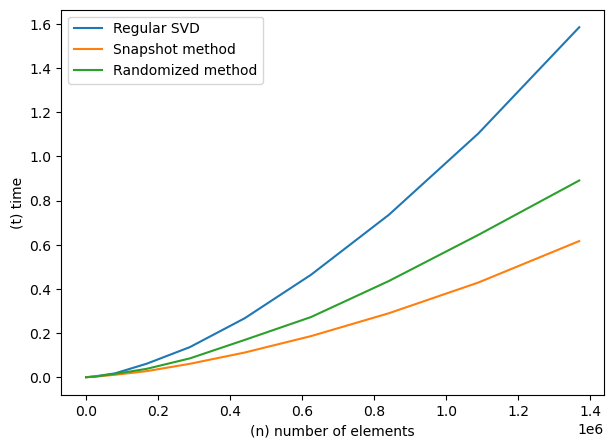

In [16]:
import time

benchmark_dictionary={'Regular SVD': [], 'Snapshot method': [], 'Randomized method': []}
function_dictionary={'Regular SVD': lambda x: x @ x.T , 'Snapshot method': lambda x: snapshot_svd(x), 'Randomized method': lambda x: randomized_q(x,2)}



for s_x,s_y in zip(np.arange(100,4000,400), np.arange(10,400,40)):
 
    RT_matrix=np.random.rand(s_x,s_y)

    for elem in benchmark_dictionary.keys():
        start=time.time()
        function_dictionary[elem](RT_matrix)
        end=time.time()
        benchmark_dictionary[elem].append(end-start)

fig, ax = plt.subplots(figsize=(7,5))


for elem in benchmark_dictionary.keys():
    ax.plot((np.arange(10,400,40)*np.arange(100,4000,400)),benchmark_dictionary[elem], label=elem)
ax.set_xlabel('(n) number of elements')
ax.set_ylabel('(t) time')
ax.legend()